## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# # performs the camera calibration, image distortion correction and 
# # returns the undistorted image
# def cal_undistort(img, objpoints, imgpoints):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, 
#     gray.shape[::-1], None, None)
#     undist = cv2.undistort(img, mtx, dist, None, mtx)  
#     return undist

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)        
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
    #print(idx)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
#         cv2.imshow('img', img)
#         cv2.waitKey(500)
#cv2.destroyAllWindows()


In [2]:
# Test undistortion on a road image
img = cv2.imread('test_images/test5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

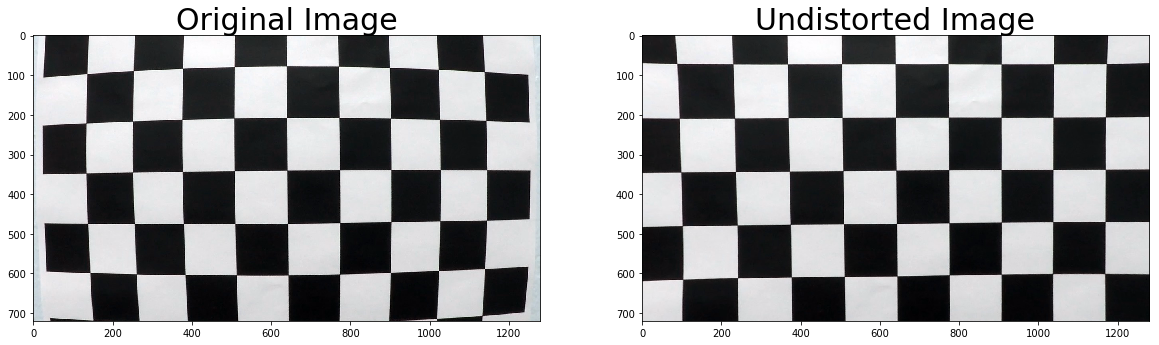

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('../camera_cal/test_undist.jpg', dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

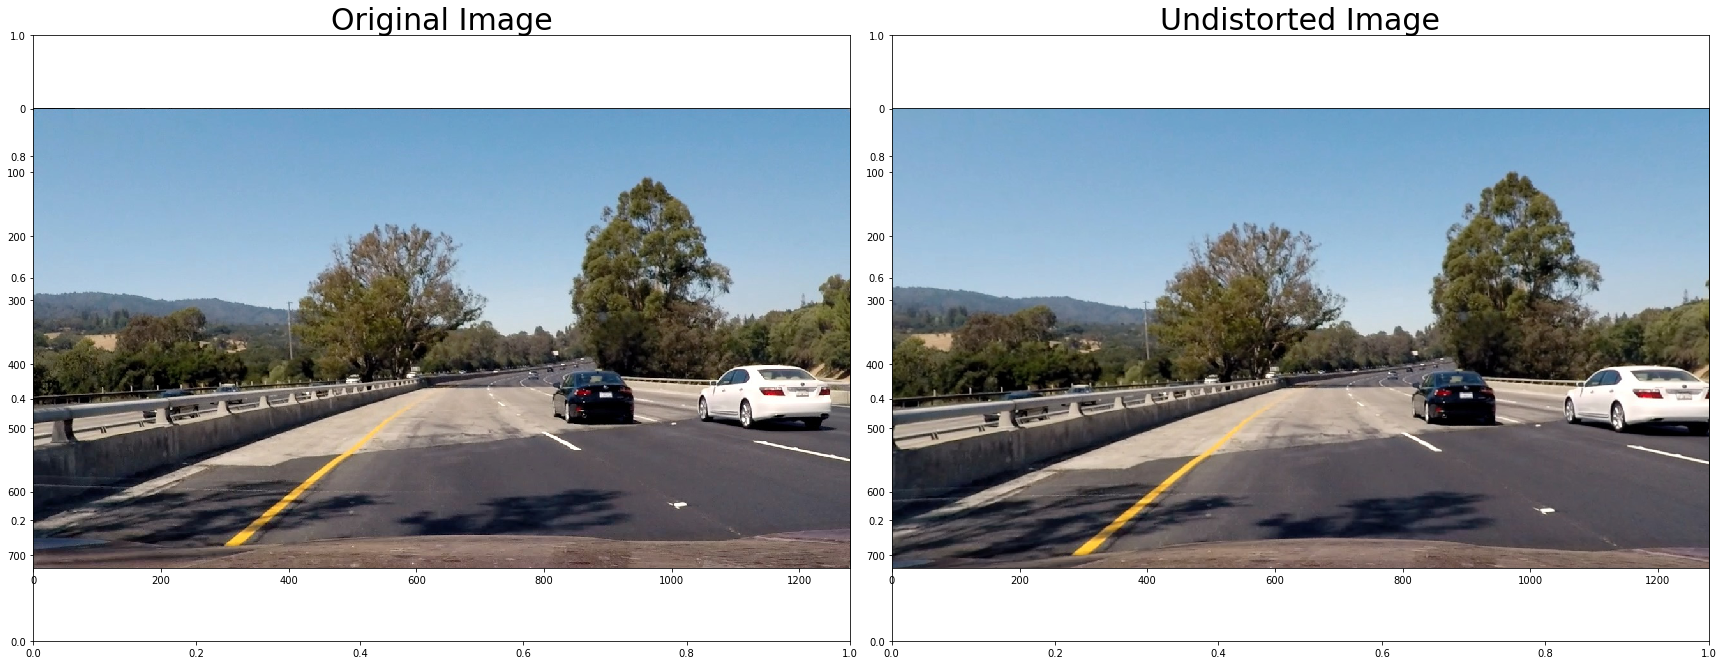

In [4]:
# Test undistortion on an image
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()

img = plt.imread('test_images/test4.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

fig.add_subplot(1,2,1)
ax1.set_title('Original Image', fontsize=30)
plt.imshow(img)
fig.add_subplot(1,2,2)
ax2.set_title('Undistorted Image', fontsize=30)
plt.imshow(dst)

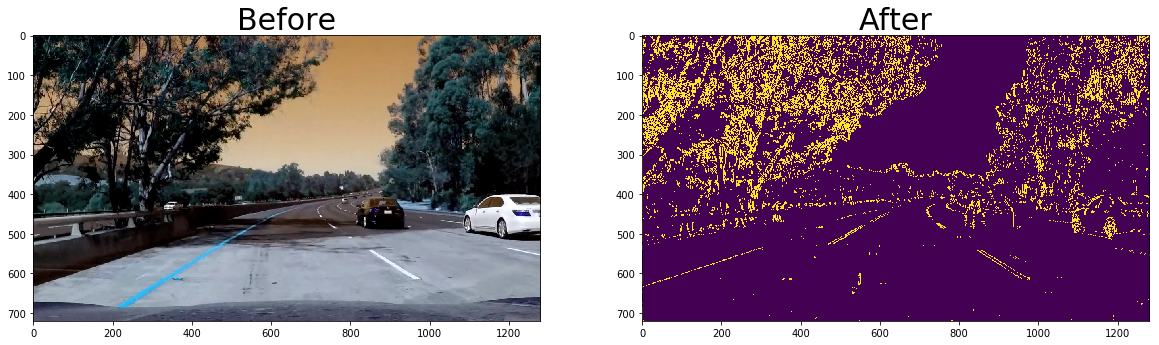

In [5]:
#Construct Binary Image

def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = []
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # 5) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return sxbinary  # binary_output

img = cv2.imread('test_images/test5.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Before', fontsize=30)
ax2.imshow(abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=120))
ax2.set_title('After', fontsize=30)

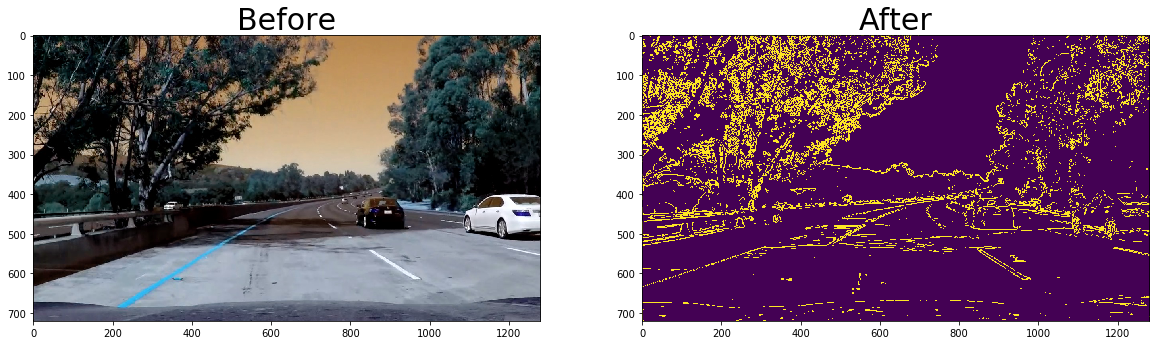

In [6]:
# Define a function that applies Sobel x and y,
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude
    magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * magnitude / np.max(magnitude))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1  
    return binary_output

img = cv2.imread('test_images/test5.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Before', fontsize=30)
ax2.imshow(mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)))
ax2.set_title('After', fontsize=30)

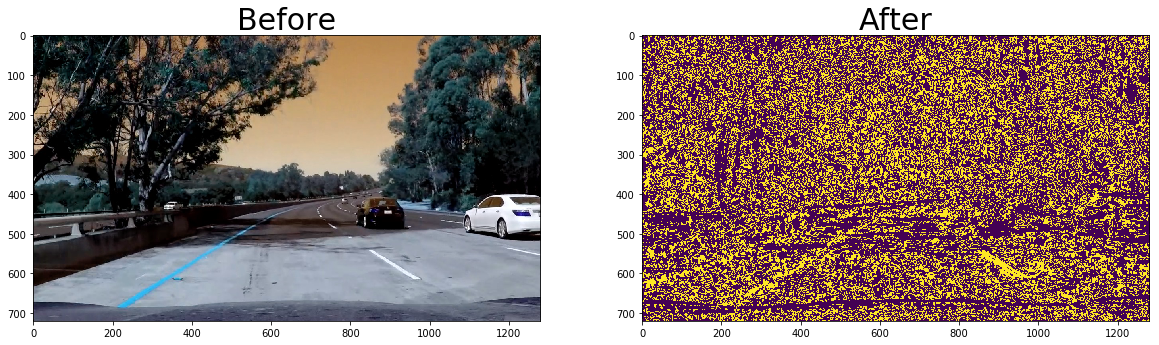

In [7]:
# Define a function that applies Sobel x and y,
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_x = np.absolute(sobel_x)
    abs_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dir_gra = np.arctan2(abs_y, abs_x)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_gra)
    # 6) Return this mask as your binary_output image
    binary_output[(dir_gra >= thresh[0]) & (dir_gra <= thresh[1])] = 1
    return binary_output

img = cv2.imread('test_images/test5.jpg')
# Run the function
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Before', fontsize=30)
ax2.imshow(dir_binary)
ax2.set_title('After', fontsize=30)

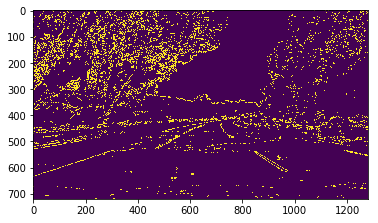

In [8]:
# Choose a Sobel kernel size
ksize = 5  # Choose a larger odd number to smooth gradient measurements
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=120)
grady = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=150)
mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.5))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined)

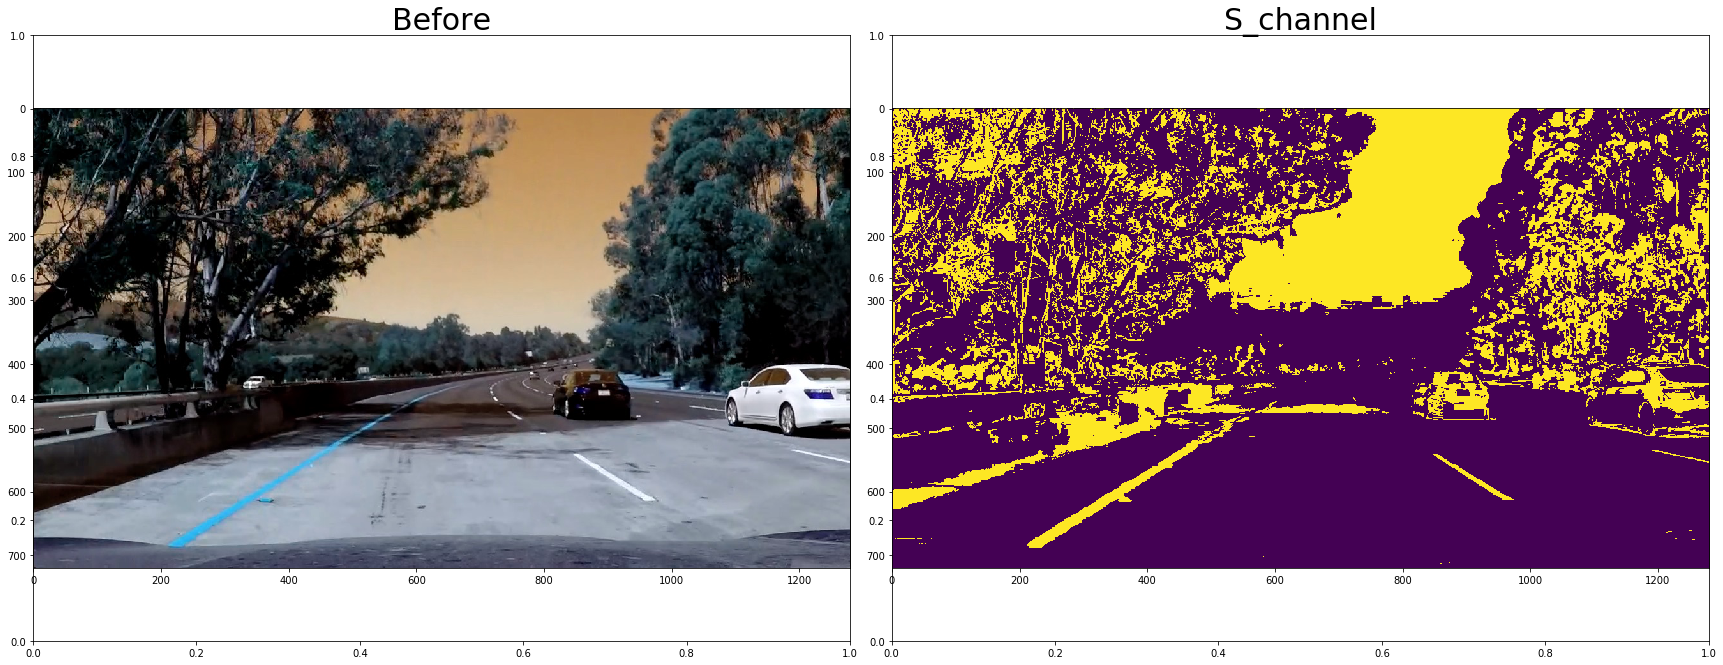

In [9]:
# HLS
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

thresh = (90, 255)
binary_s = np.zeros_like(S)
binary_s[(S > thresh[0]) & (S <= thresh[1])] = 1

thresh = (15, 100)
binary_h = np.zeros_like(H)
binary_h[(H > thresh[0]) & (H <= thresh[1])] = 1

R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]
thresh = (150, 255)
binary_r = np.zeros_like(R)
binary_r[(R > thresh[0]) & (R <= thresh[1])] = 1

fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()

fig.add_subplot(1,2,1)
ax1.set_title('Before', fontsize=30)
plt.imshow(img)
fig.add_subplot(1,2,2)
ax2.set_title('S_channel', fontsize=30)
plt.imshow(binary_s)


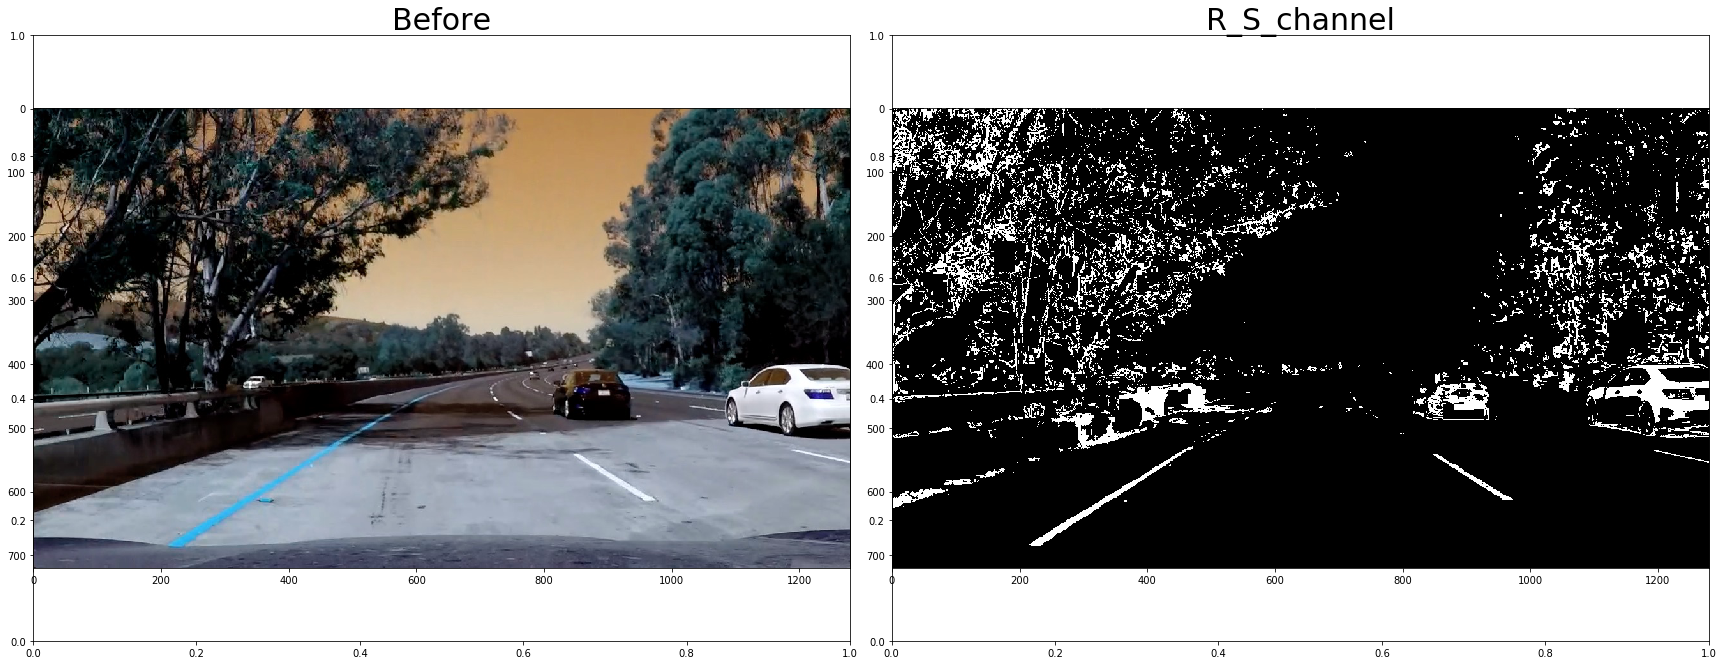

In [10]:
# Combine R and S channel
def r_s_chanel(img, thresh_r = (220, 255), thresh_s=(170,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    s_binary = np.zeros_like(S)
    s_binary[(S >= thresh_s[0]) & (S <= thresh_s[1])] = 1
    
    R = img[:,:,0]
    r_binary = np.zeros_like(R)
    r_binary[(R >= thresh_r[0]) & (R <= thresh_r[1])] = 1
    
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     # Sobel x
#     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
#     abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
#     scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
#     # Threshold x gradient
#     thresh_min = 20
#     thresh_max = 100
#     sxbinary = np.zeros_like(scaled_sobel)
#     sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (r_binary == 1)] = 1

    
#     binary_rs[((R > thresh_r[0]) & (R <= thresh_r[1]))
#               | ((S > thresh_s[0]) & (S <= thresh_s[1]))] = 1
    return combined_binary
    
img = cv2.imread('test_images/test5.jpg')
#img = cv2.imread('extracted_img/frame1258.jpg')
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()

fig.add_subplot(1,2,1)
ax1.set_title('Before', fontsize=30)
plt.imshow(img)
fig.add_subplot(1,2,2)
ax2.set_title('R_S_channel', fontsize=30)
plt.imshow(r_s_chanel(img), cmap='gray')


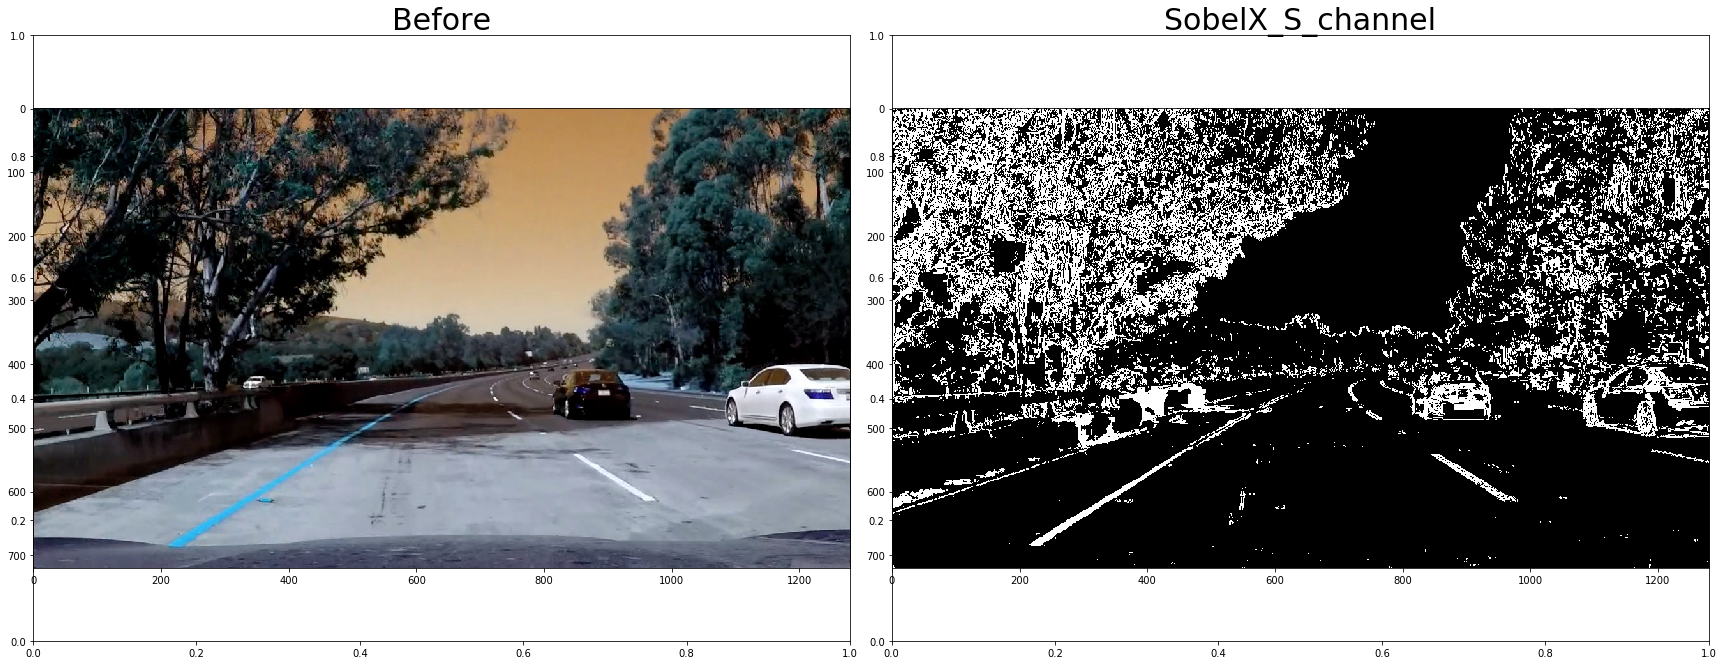

In [11]:
# Combine SobelX, S channel, and other channels
def sobelx_s_chanel(img, thresh_sobel=(20,100), thresh_s=(170,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    s_binary = np.zeros_like(S)
    s_binary[(S >= thresh_s[0]) & (S <= thresh_s[1])] = 1
    
    abs_sobel_bin = abs_sobel_thresh(img, orient='x', thresh_min=50, thresh_max=255)
    mag_bin = mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    
#     R = img[:,:,0]
#     r_binary = np.zeros_like(R)
#     r_binary[(R >= thresh_r[0]) & (R <= thresh_r[1])] = 1
    thresh_r = (200, 255)
    R = img[:,:,0]
    r_binary = np.zeros_like(R)
    r_binary[(R >= thresh_r[0]) & (R <= thresh_r[1])] = 1
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_sobel[0]) & (scaled_sobel <= thresh_sobel[1])] = 1

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(abs_sobel_bin == 1) |((mag_bin == 1) & (dir_binary == 1)) 
                    | (s_binary == 1) | (sxbinary == 1)] = 1  #| (r_binary == 1)
    return combined_binary
    
#     binary_rs[((R > thresh_r[0]) & (R <= thresh_r[1]))
#               | ((S > thresh_s[0]) & (S <= thresh_s[1]))] = 1
#     return binary_rs
#     thresh_r = (200, 255)
#     thresh_s = (175, 255)
#     binary_rs = np.zeros_like(R)
#     binary_rs[(R > thresh_r[0]) & (R <= thresh_r[1]) & (S > thresh_s[0]) & (S <= thresh_s[1])] = 1
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()

fig.add_subplot(1,2,1)
ax1.set_title('Before', fontsize=30)
plt.imshow(img)
fig.add_subplot(1,2,2)
ax2.set_title('SobelX_S_channel', fontsize=30)
plt.imshow(sobelx_s_chanel(img, thresh_sobel=(20,100), thresh_s=(170,255)),cmap='gray')



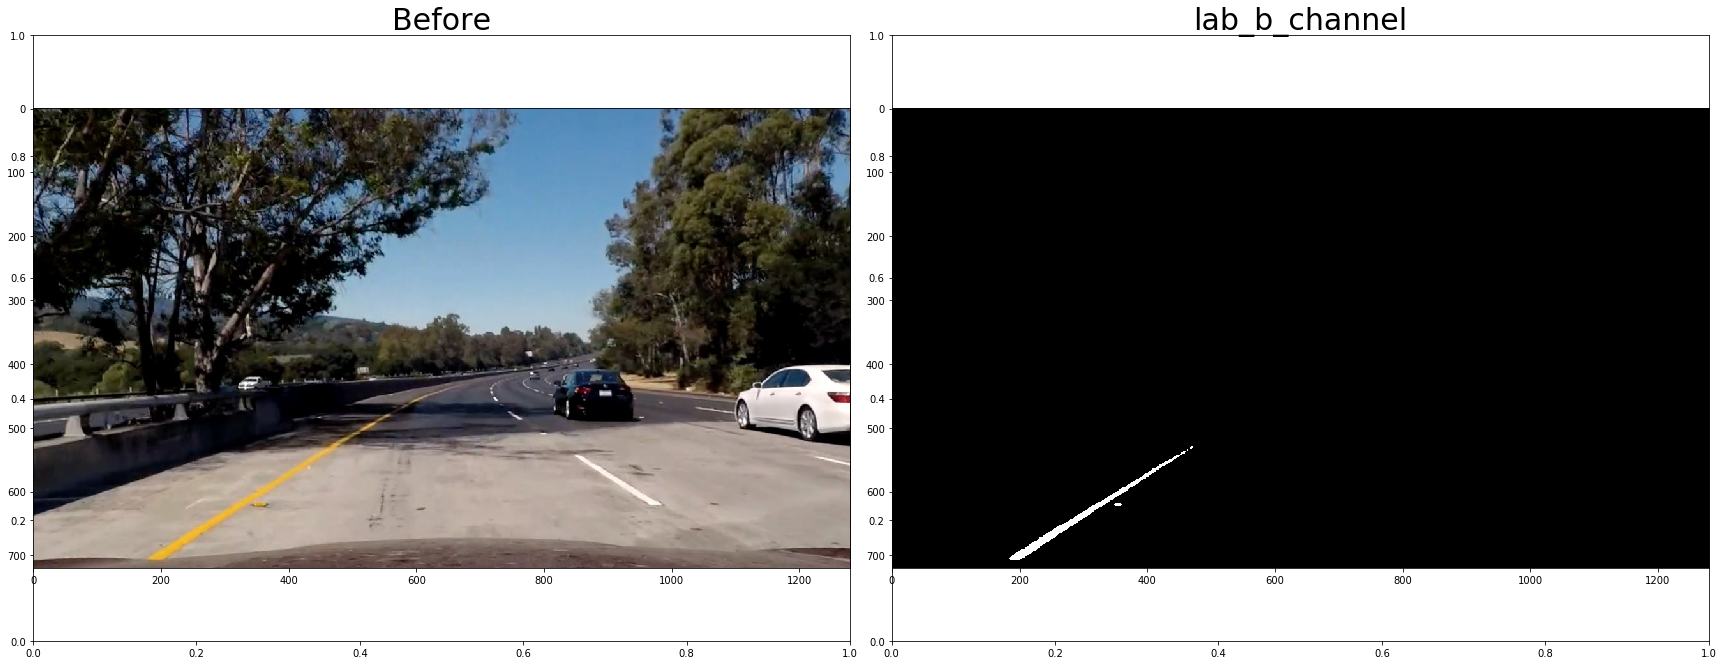

In [12]:
# get yellow
def lab_b(img, thresh=(190,255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    return binary_output

fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()

img = plt.imread('test_images/test5.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
fig.add_subplot(1,2,1)
ax1.set_title('Before', fontsize=30)
plt.imshow(img)
fig.add_subplot(1,2,2)
ax2.set_title('lab_b_channel', fontsize=30)
plt.imshow(lab_b(img, thresh=(180,255)),cmap='gray')


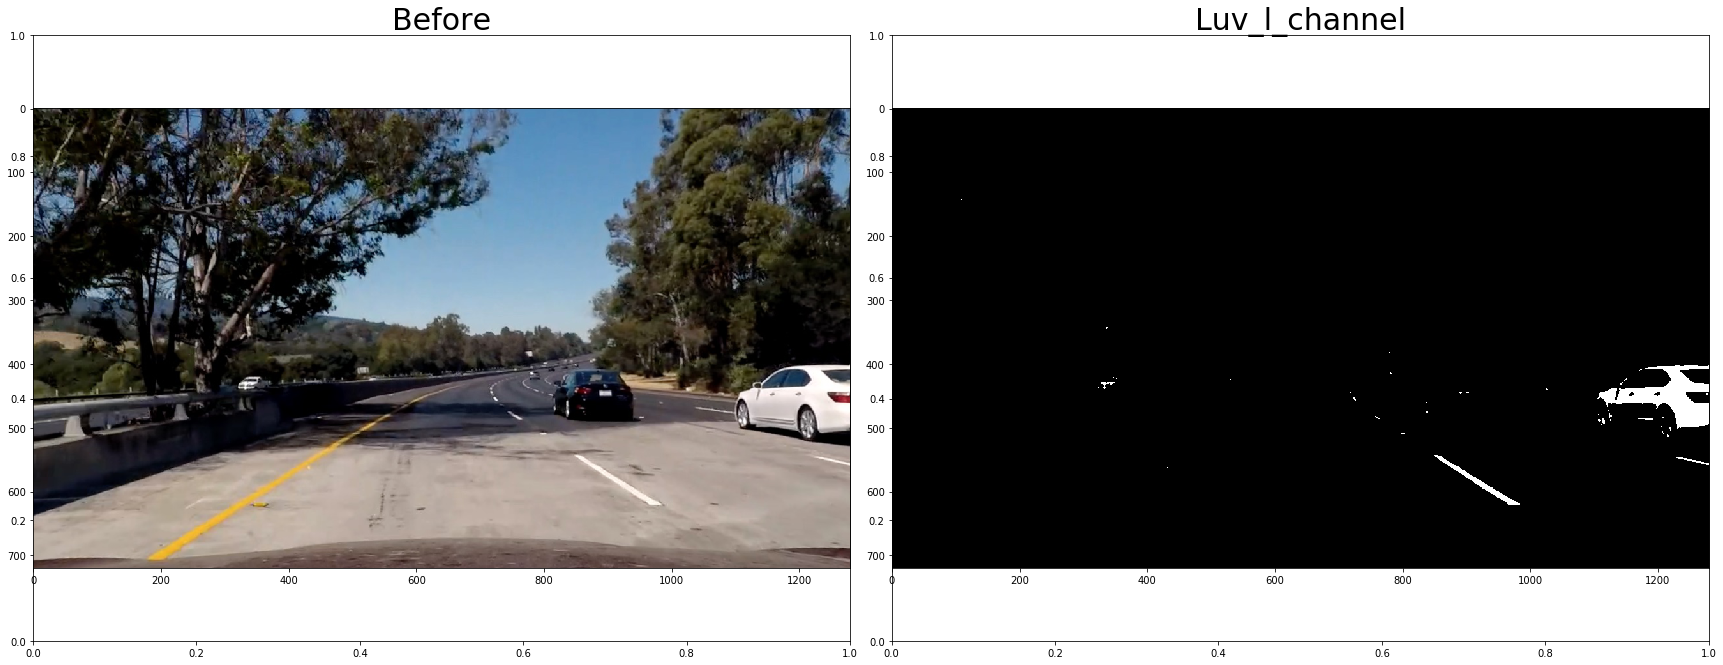

In [13]:
def luv_l(img):
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    L = luv[:,:,0]
    thresh=(215, 255)
    binary_l = np.zeros_like(L)
    binary_l[(L > thresh[0]) & (L <= thresh[1])] = 1
    return binary_l

fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()

img = plt.imread('test_images/test5.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
fig.add_subplot(1,2,1)
ax1.set_title('Before', fontsize=30)
plt.imshow(img)
fig.add_subplot(1,2,2)
ax2.set_title('Luv_l_channel', fontsize=30)
plt.imshow(luv_l(img),cmap='gray')



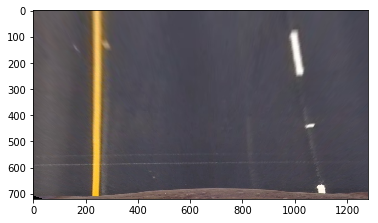

In [48]:
# Warp transform
def warp(img):
    length = gray.shape[1]
    width = gray.shape[0]
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], [1250, 720],  [40, 720]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    size = (gray.shape[1], gray.shape[0])
    warped = cv2.warpPerspective(img, M, size, flags=cv2.INTER_LINEAR)
    return warped, Minv

img = plt.imread('test_images/straight_lines1.jpg')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
img = cv2.undistort(img, mtx, dist, None, mtx)
#img = sobelx_s_chanel(img)
dst,Minv = warp(img)
plt.imshow(dst)

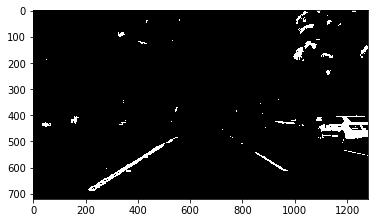

In [71]:
# test on different combinations of 
def combined_chanel(img):
    #img,Minv = warp(img)
#     ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
#     undist = cv2.undistort(img, mtx, dist, None, mtx)
#     img, Minv = warped(undist)

    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    b_thresh_min = 150
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    # Set the upper and lower thresholds for the l channel
    l_thresh_min = 210
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    res = np.zeros_like(b_binary)
    res[(l_binary == 1) | (b_binary == 1)] = 1
    return res
img = plt.imread('test_images/test5.jpg')
plt.imshow(combined_chanel(img),cmap='gray')

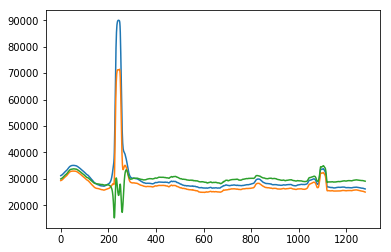

In [19]:
# Histogram
histogram = np.sum(dst[int(dst.shape[0]/2):,:], axis=0)
plt.plot(histogram)

In [21]:
# Define y-value where we want radius of curvature
def get_curvature(leftx, rightx, lefty, righty):
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = 720 #np.max(ploty)
#     left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
#     right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad
    # Example values: 632.1 m    626.2 m
#print(get_curvature(leftx, rightx, lefty, righty))

In [22]:
# calculate offset, the distance between image center and lane center
def get_offset(undist, left_fit, right_fit, ploty):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = undist.shape[0]-1 # height
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    offset = (left_fitx+right_fitx)/2 - undist.shape[1]/2 # width
    offset = xm_per_pix*offset

    return offset
    

In [60]:
from collections import deque
class Line:
    def __init__(self):
        # was the line found in the previous frame?
        self.found = False
        
        # previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # recent x intercepts for averaging frames (max value of 10 frames)
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # radius of curvature
        self.radius = None
        
        # to make lane smooth, keep recent polynomial coefficients for averaging frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # count the number of frames
        self.count = 0
        
    # calculate radius
    def radius_of_curvature(self, xvals, yvals):
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        ym_per_pix = 30./720 # meters per pixel in y dimension
        fit_cur = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        rad = ((1 + (2*fit_cur[0]*np.max(yvals) + fit_cur[1])**2)**1.5)/np.absolute(2*fit_cur[0])
        return rad
     
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top
    
    # Not find lane previously
    # Sliding window search to detect peaks in a histogram of the image,  (+/- 25 px)   
    def pre_not_found(self, x, y, image):
        
        x_val = []
        y_val = []

        if not self.found:
            wide = 720
            hi = 630
            while hi >= 0:
                histogram = np.sum(image[hi:wide,:], axis=0)
                midpoint = np.int(histogram.shape[0]/2)
                if self == Left:
                    #peak = np.argmax(histogram[:midpoint])
                    peak = np.argmax(histogram[:640])
                else:
                    #peak = np.argmax(histogram[midpoint:]) + midpoint
                    peak = np.argmax(histogram[640:]) + 640
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > hi) & (y < wide))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    x_val.extend(x_window)
                    y_val.extend(y_window)
                wide -= 90
                hi -= 90
        if np.sum(x_val) > 0:
            self.found = True
        else:
            x_val = self.X
            y_val = self.Y

        return x_val, y_val, self.found
        
    
    # find lane in previous frame, so just search close area, (+/- 25 px)   
    def pre_found(self, x, y):
        x_val = []
        y_val = []

        if self.found:
            wide = 720
            hi = 630
            while hi >= 0:
                yval = np.mean([wide, hi])
                xval = (np.mean(self.fit0) * yval ** 2 + (np.mean(self.fit1) * yval) + np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > hi) & (y < wide))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(x_val, x_window)
                    np.append(y_val, y_window)                
                wide -= 90
                hi -= 90
        if np.sum(x_val) == 0:
            self.found = False
        return x_val, y_val, self.found
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals


In [72]:
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML

def process_image(image):
    img_size = (image.shape[1], image.shape[0])
    # Calibrate camera 
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    #offset = 0
    warped, Minv = warp(undist)
    combined_binary = combined_chanel(warped)
    
    # only focus on all non zero pixels 
    x, y = np.nonzero(np.transpose(combined_binary)) 

    if Left.found: # search near area 
        leftx, lefty, Left.found = Left.pre_found(x, y)
        
    if Right.found: 
        rightx, righty, Right.found = Right.pre_found(x, y)

    if not Right.found: # previously not found
        rightx, righty, Right.found = Right.pre_not_found(x, y, combined_binary)
            
    if not Left.found: # previously not found
        leftx, lefty, Left.found = Left.pre_not_found(x, y, combined_binary)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # left polynomial fit
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # average intercepts of n frames, n <= 10
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    leftx, lefty = Left.sort_vals(leftx, lefty)
    Left.X = leftx
    Left.Y = lefty
    
    # recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), np.mean(Left.fit1), np.mean(Left.fit2)]
    
    # fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # similarly for right
    # right polynomial fit 
    right_fit = np.polyfit(righty, rightx, 2)

    # calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # average intercepts 
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    # sort right lane pixels
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
     
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # radius of curvature for each lane in meters
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
    # print the radius of curvature every 2 frames 
    if Left.count % 2 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    Left.count += 1    
    # calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = (640 - position)*3.7/700 
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
    
    
    road_curv = int((Left.radius + Right.radius) / 2)
    road_text = 'Radius of average curvature: %.2f m'%road_curv
    cv2.putText(result, road_text,(60,60), 0, 1, (0,255,0), 2, cv2.LINE_AA)
    
    if (distance_from_center > 0):
        offset_test = "{:.2f}".format(distance_from_center) + "m right of center"
    else: 
        offset_test = "{:.2f}".format(-distance_from_center) + "m left of center"
    cv2.putText(result, offset_test,(60,90), 0, 1, (0,255,0), 2, cv2.LINE_AA)
    
    return result


In [73]:
Left = Line()
Right = Line()
yellow_output = 'project_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('project_video.mp4').subclip(46,50)
clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video project_output4.mp4
[MoviePy] Writing video project_output4.mp4


100%|█████████▉| 1260/1261 [18:15<00:00,  1.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output4.mp4 

CPU times: user 18min 30s, sys: 27.9 s, total: 18min 58s
Wall time: 18min 16s
